In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
import numpy as np

In [10]:
data = pd.read_csv('fer2013.csv')

In [11]:
data

emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]

In [21]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [22]:
data['Usage'].value_counts()


Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [23]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [24]:
#Define training, validation and test data:

train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

In [25]:
#Reshape and scale the images:

train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [26]:
#Encoding of the target value:

train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

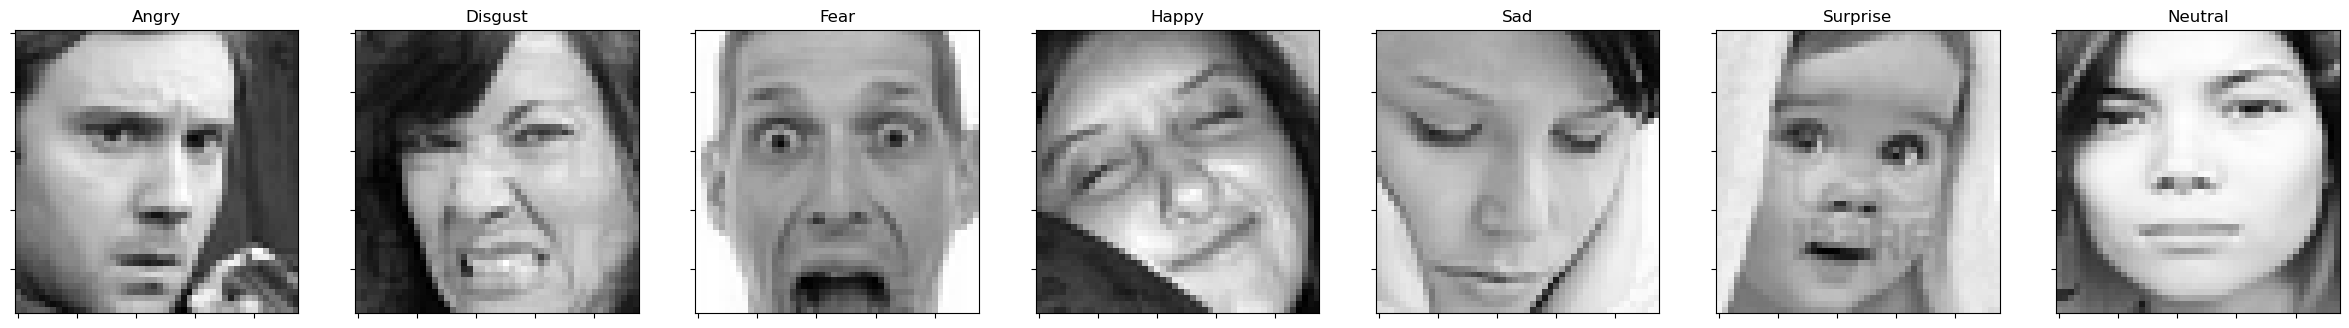

In [27]:
plot_all_emotions()

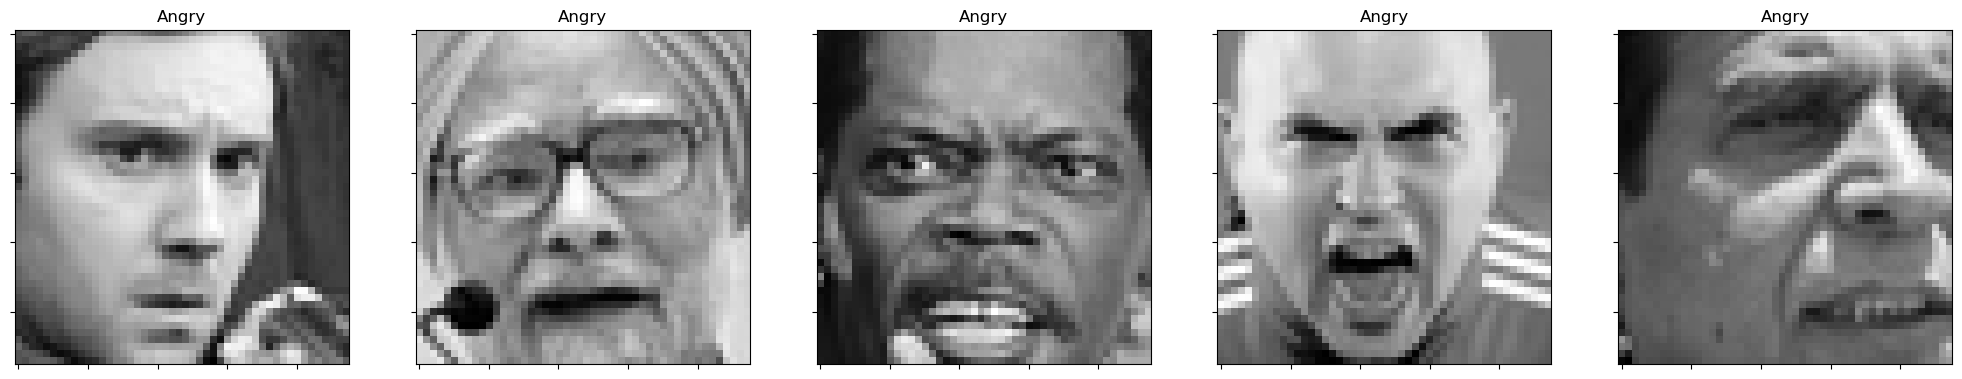

In [32]:
#angry
plot_examples(label=0)


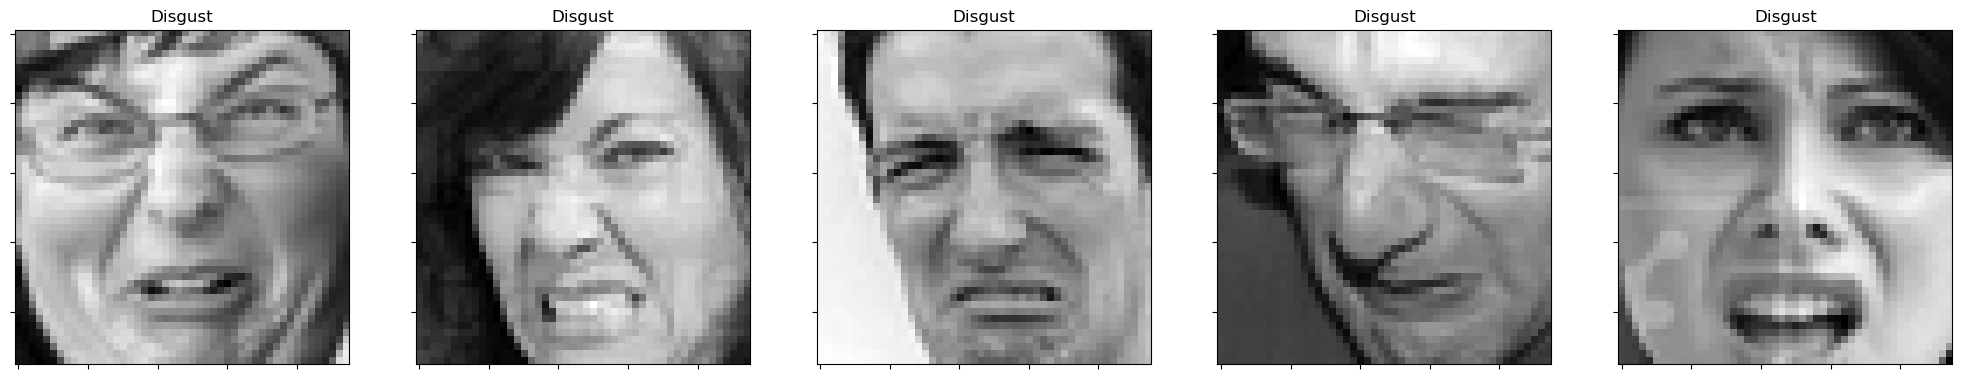

In [33]:
#disgust
plot_examples(label=1)


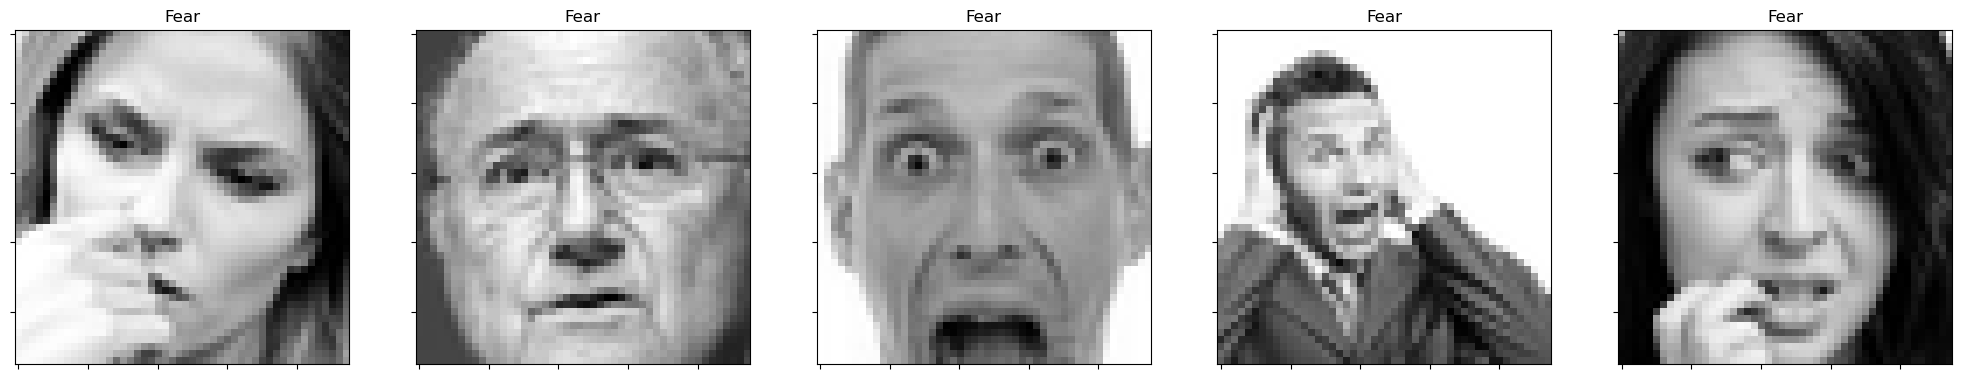

In [34]:
#fear 
plot_examples(label=2)


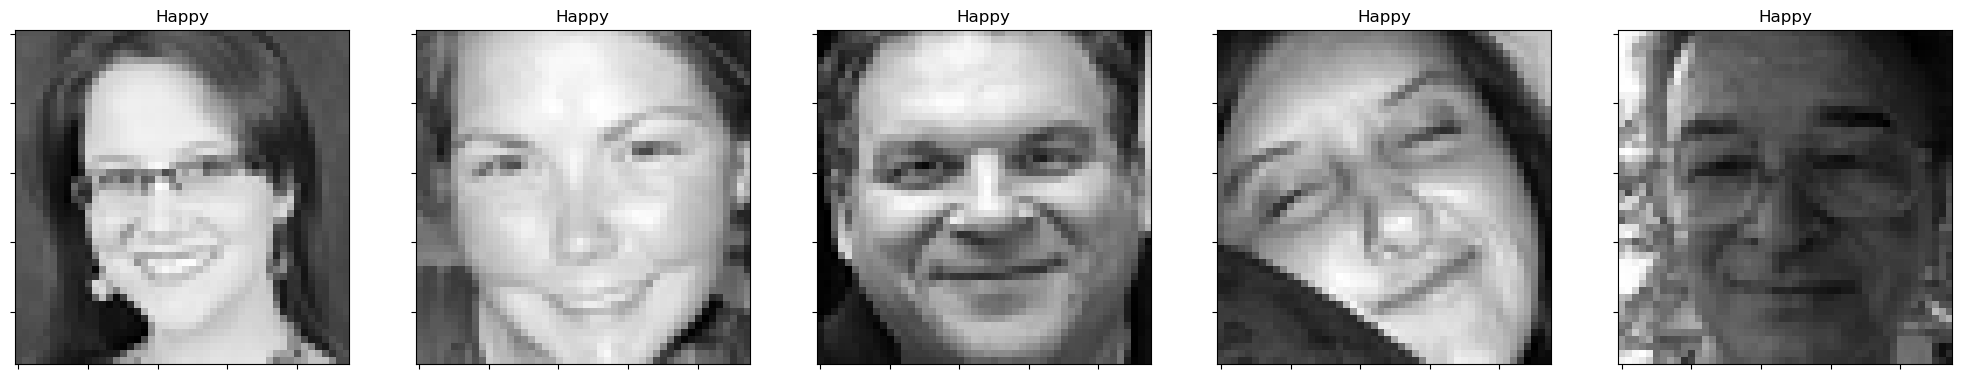

In [35]:
#happy 
plot_examples(label=3)


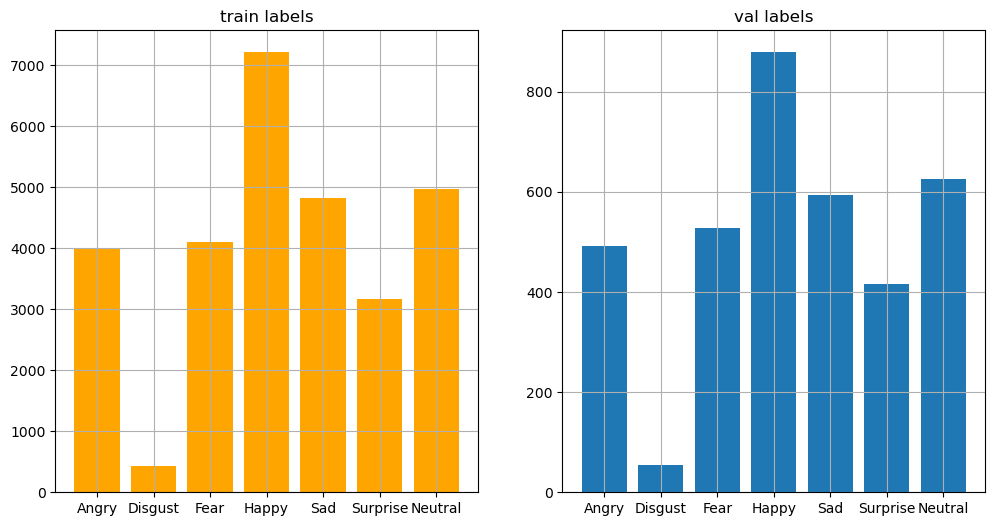

In [36]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

In [39]:
class_weight = dict(zip(range(0, 7), (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data['Usage']=='Training']['emotion'])).tolist()))

In [40]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

CNN MODEL

In [62]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 4096)             

In [66]:
from tensorflow.keras.optimizers import Adam

# Define the learning rate
learning_rate = 0.001

# Compile the model with Adam optimizer and specified learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])


In [67]:
# Define learning rate scheduler callback
lr_callback = LearningRateScheduler(lr_scheduler)

# Train the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight=class_weight,
                    epochs=12,
                    batch_size=64,
                    callbacks=[lr_callback])

Epoch 1/12
449/449 [==============================] - 30s 65ms/step - loss: 0.2671 - accuracy: 0.3127 - val_loss: 1.5663 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 2/12
449/449 [==============================] - 29s 64ms/step - loss: 0.2255 - accuracy: 0.4387 - val_loss: 1.4026 - val_accuracy: 0.4700 - lr: 9.0000e-04
Epoch 3/12
449/449 [==============================] - 30s 66ms/step - loss: 0.2051 - accuracy: 0.4896 - val_loss: 1.3714 - val_accuracy: 0.4817 - lr: 8.1000e-04
Epoch 4/12
449/449 [==============================] - 30s 67ms/step - loss: 0.1938 - accuracy: 0.5230 - val_loss: 1.3189 - val_accuracy: 0.4987 - lr: 7.2900e-04
Epoch 5/12
449/449 [==============================] - 29s 66ms/step - loss: 0.1843 - accuracy: 0.5475 - val_loss: 1.3379 - val_accuracy: 0.5026 - lr: 6.5610e-04
Epoch 6/12
449/449 [==============================] - 29s 64ms/step - loss: 0.1765 - accuracy: 0.5680 - val_loss: 1.2933 - val_accuracy: 0.5224 - lr: 5.9049e-04
Epoch 7/12
449/449 [==================

In [68]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 10ms/step - loss: 1.2600 - accuracy: 0.5506
test caccuracy: 0.5505712032318115


In [69]:
pred_test_labels = model.predict(test_images)


113/113 [==============================] - 1s 10ms/step


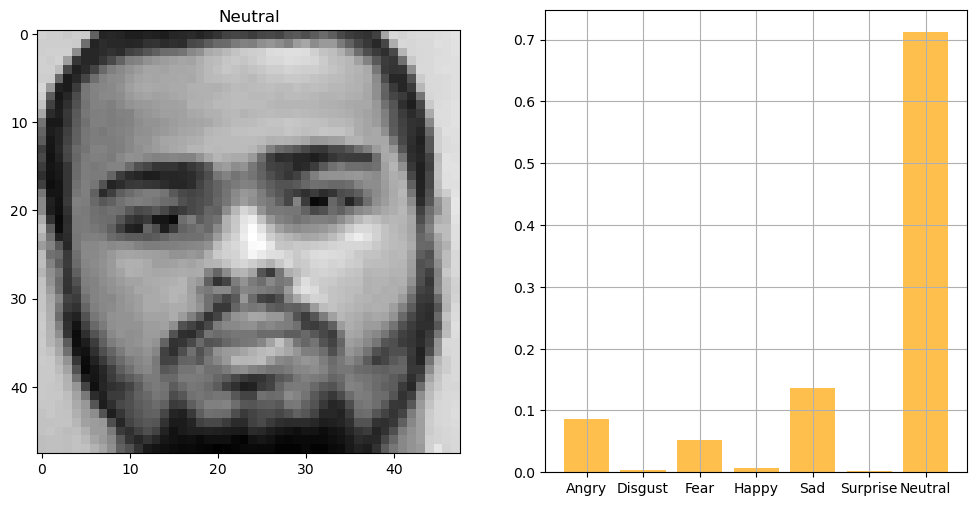

In [70]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)


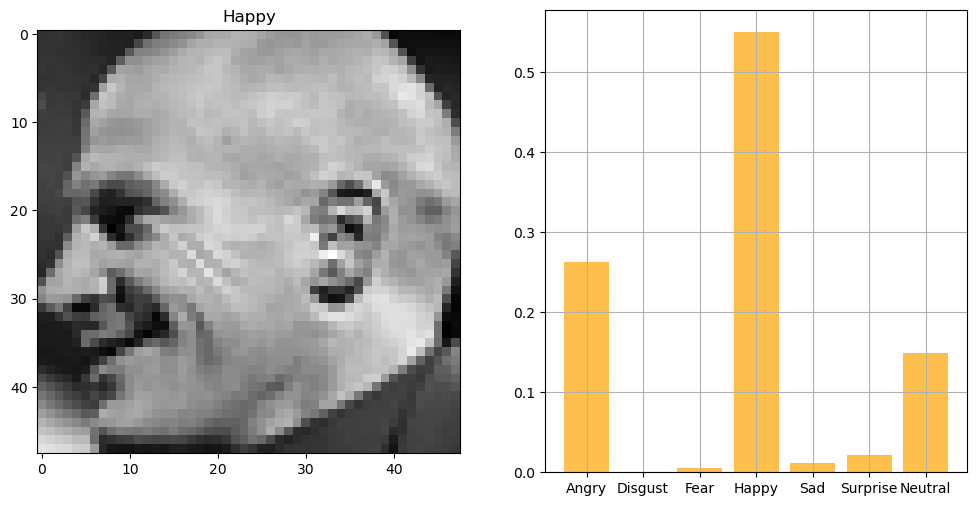

In [71]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 45)
